In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
import time
import torch.nn as nn

In [2]:
torch.manual_seed(42)
np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 2
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20

In [3]:
from cluster_tools import kmeans_elbow, ClusterSampler

Samplers

In [4]:
from torch import nn

LAMBDA = 1e-7

class LogisticLossModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=False)
        self.layer.weight.data.fill_(3)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten()
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.pow(x - 1, 2)/2
        return res.flatten() + LAMBDA*self.layer.weight.norm()

def regress_criterion(output, batch):
    return output.mean()

In [25]:
from sklearn.datasets import make_blobs
clustered_data,_ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)
clustered_data = clustered_data.astype(np.float32)

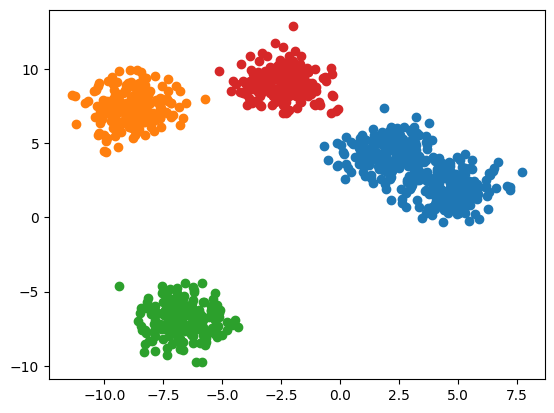

In [26]:
sampler = ClusterSampler(clustered_data, 64)
for i in range(sampler.cluster_count):
    selected = clustered_data[sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.show()

Displaying what the clusters look like after evaluating the gradients

Solvers

In [46]:
# finding an exact solution

from tqdm import tqdm

model = LogisticLossModel(clustered_data)

full_batch = torch.from_numpy(clustered_data)
n_epoch = 10000
losses = np.zeros(n_epoch)
lr = 0.001

for i in tqdm(range(n_epoch)):
    model.zero_grad()
    output = model(full_batch)
    loss = regress_criterion(output, "")
    loss.backward()
    for p in model.parameters():
        p.data.sub_(lr*p.grad.data)
    losses[i] = loss.item()

opt_val = losses[-1]
opt_val

100%|██████████| 10000/10000 [00:03<00:00, 2521.37it/s]


np.float64(0.3219119906425476)

In [48]:
from solvers import solve_problem, svrg, COVER

In [49]:
from utils import clone_model

In [50]:
NB_EPOCH = None
TIME_LIM = 10
BATCH_SIZE = 64

In [51]:
base_model = LogisticLossModel(clustered_data)

In [52]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM)

  1%|          | 566/100000 [00:09<29:16, 56.62it/s]


In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     clustered_data,
                     RandomSampler(clustered_data),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=0.0001)

  0%|          | 25/100000 [00:10<11:20:08,  2.45it/s]


In [104]:
from torch.utils.data import Sampler
from sklearn.cluster import KMeans
from solvers import calc_grad

def clusterSVRG(model:nn.Module,
         loss_function,
         data,
         sampler:Sampler,
         *model_args,
         n_epoch,
         time_lim=None,
         learning_rate=0.001, # for correspondance with torch.optim function
         ):
    """
    See https://arxiv.org/abs/1602.02151
    """
    assert n_epoch or time_lim, "No limit to the number of iterations"

    total_loss_epoch = []
    timestamps = []
    dataset = torch.from_numpy(data)
    n = len(dataset)

    cluster_count = kmeans_elbow(dataset)
    kmeans_res = KMeans(n_clusters=cluster_count).fit(dataset)
    cluster_probs = np.zeros(cluster_count)
    for l in kmeans_res.labels_:
        cluster_probs[l] += 1
    cluster_probs /= np.sum(cluster_probs)


    begin_t = time.perf_counter()
    if n_epoch is None:
        n_epoch = 100000
    for epoch in tqdm(range(n_epoch)):
        #Compute full grad
        previous_net = clone_model(model, *model_args) # for calculating gradient each step
        previous_net.zero_grad()
        # l = calc_grad(previous_net, dataset, None, loss_function).item()
        # print(l)
        total_loss_epoch.append(
            calc_grad(previous_net, dataset, None, loss_function).item())
        previous_net_grads = [p.grad.data for p in previous_net.parameters()]

        z_cluster = [[torch.zeros_like(p) for p in model.parameters()]
                    for _ in range(cluster_count)]
        z_total = [torch.zeros_like(p) for p in model.parameters()]
        for data_id in sampler:
            batch = dataset[data_id]

            previous_net.zero_grad()
            prev_loss = calc_grad(previous_net, batch, "", loss_function)

            model.zero_grad()
            curr_loss = calc_grad(model, batch, "", loss_function)
            
            curr_cluster = kmeans_res.labels_[data_id]
            for param, g_c, g_c_total, p_prev, g_total, in \
                    zip(model.parameters(),
                        z_cluster[curr_cluster],
                        z_total,
                        previous_net.parameters(), 
                        previous_net_grads):
                grad = param.grad.data
                prev_grad = p_prev.grad.data
                param.data.sub_(learning_rate*(g_total + g_c_total + grad - (g_c + prev_grad)))
                # g_c_total.add_(cluster_probs[curr_cluster]*(grad - prev_grad - g_c))
                # g_c = grad - prev_grad
        
        elapsed_t = time.perf_counter()-begin_t
        timestamps.append(elapsed_t)
        if time_lim and elapsed_t > time_lim:
            break

    return np.array(timestamps), np.array(total_loss_epoch), model

In [105]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     clustered_data,
                     RandomSampler(clustered_data),
                     clustered_data,
                     n_epoch=None,
                     time_lim=10,
                     learning_rate=0.01)

  0%|          | 14/100000 [00:10<19:51:29,  1.40it/s]


In [107]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(clustered_data, len(clustered_data), shuffle=True),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True)

Building models...


  3%|▎         | 2625/100000 [00:10<06:11, 262.16it/s]


In [111]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(clustered_data, 1, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM)

  0%|          | 13/100000 [00:10<22:40:41,  1.22it/s]


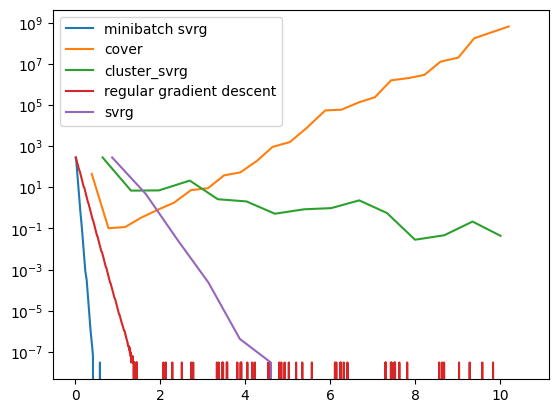

In [112]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [55]:
from utils import clone_model

In [56]:
sgd_time, sgd_sol, opt_model = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 790/100000 [00:09<20:55, 79.05it/s]


In [57]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 721/100000 [00:09<22:55, 72.20it/s]


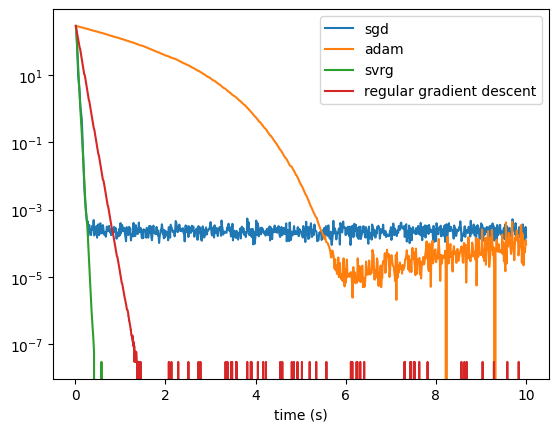

In [110]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [59]:
iid_sampler = RandomSampler(clustered_data, replacement=True)
iid_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [60]:
adam_iid_time, adam_sol_iid, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=iid_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 705/100000 [00:09<23:28, 70.51it/s]


In [61]:
cluster_sampler = ClusterSampler(clustered_data, BATCH_SIZE)
cluster_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [62]:
adam_cluster_time, adam_sol_cluster, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=cluster_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 711/100000 [00:09<23:15, 71.13it/s]


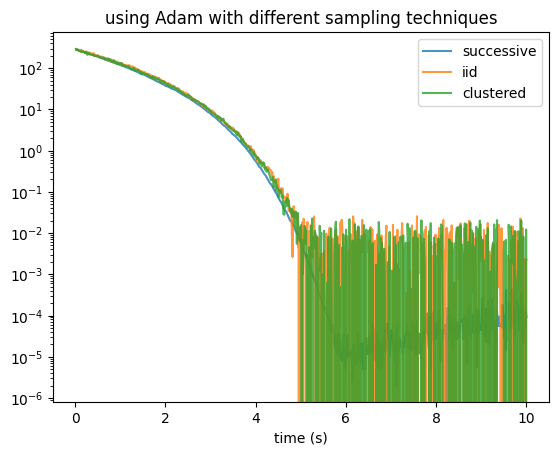

In [63]:
plt.plot(adam_time, adam_sol-opt_val, label="successive", alpha=0.8)
plt.plot(adam_iid_time, adam_sol_iid-opt_val, label="iid", alpha=0.8)
plt.plot(adam_cluster_time, adam_sol_cluster-opt_val, label="clustered", alpha=0.8)
plt.xlabel("time (s)")
plt.yscale("log")
plt.legend()
plt.title("using Adam with different sampling techniques")
plt.show()

In [64]:
sgd_iid_time, sgd_sol_iid, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=iid_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

sgd_cluster_time, sgd_sol_cluster, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=cluster_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 780/100000 [00:09<21:11, 78.01it/s]


Building models...


  1%|          | 795/100000 [00:09<20:46, 79.59it/s]


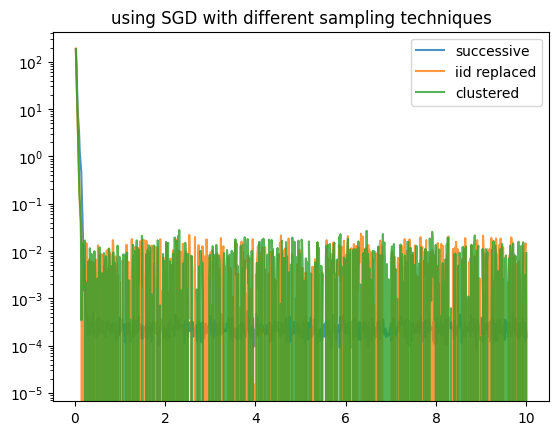

In [65]:
plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)
plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
plt.legend()
plt.yscale("log")
plt.title("using SGD with different sampling techniques")
plt.show()

In [66]:
def get_grad(batch, model):
    ret = np.zeros((len(batch), 2))
    for i, elem in enumerate(batch):
        res = model(elem)
        l = regress_criterion(res, "")
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

def display_grads(dataset, model, title=""):
    dataset_torch = torch.from_numpy(dataset)
    for i in range(sampler.cluster_count):
        selected = dataset_torch[sampler.clusters[i]]
        grad_selected = get_grad(selected, model)
        plt.scatter(grad_selected[:,0], grad_selected[:,1], alpha=0.5)

    plt.title(title)
    plt.show()

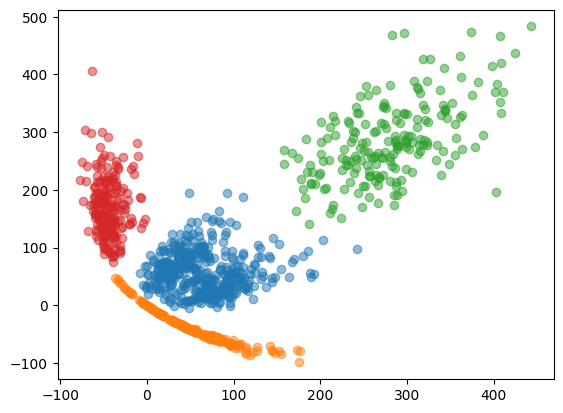

In [67]:
display_grads(clustered_data, base_model)

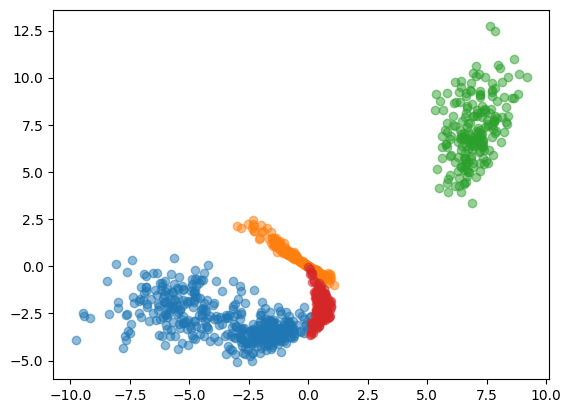

In [68]:
display_grads(clustered_data, opt_model)

In [69]:
print(opt_model.layer.weight)

Parameter containing:
tensor([[-0.0616,  0.0678]], requires_grad=True)
